In [1]:
import os
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import norm
from matplotlib import pyplot as plt
import pickle as pkl

In [5]:
class NDB:
    def __init__(self, training_data=None, number_of_bins=100, significance_level=0.05, z_threshold=None,
                    whitening=False, max_dims=None, cache_folder=None):
        """
        training_data: (optional) The training samples - array of m x d floats (m samples and d dimensions)
        number_of_bins: number of bins(clusters)- default=100
        significance_level: the significance level for the two-sample test
        z_threshold: threshold for difference/SE for defining a bin as statistically different
        whitening: subtract mean and divide by per-dimension std
        max_dims: max dimensions to use in K-means 
        bins_file: file to write/read from the clusters (to avoid re-calculations)
        """
        self.number_of_bins = number_of_bins
        self.significance_level = significance_level
        self.z_threshold = z_threshold
        self.whitening = whitening
        self.ndb_eps = 1e-6
        self.training_mean = 0.0
        self.training_std = 1.0
        self.max_dims = max_dims
        self.cache_folder = cache_folder
        self.bin_centers = None
        self.bin_proportions = None
        self.ref_sample_size = None
        self.used_d_indices = None
        self.results_file = None
        self.test_name = 'ndb_{}_bins_{}'.format(self.number_of_bins, 'whiten' if self.whitening else 'orig')
        self.cached_results = {}
        if self.cache_folder:
            self.results_file = os.path.join(cache_folder, self.test_name+'_results.pkl')
            if os.path.isfile(self.results_file):
                self.cached_results = pkl.load(open(self.results_file, 'rb'))
                
        if training_data is not None or cache_folder is not None:
            bins_file = None
            if cache_folder:
                os.makedirs(cache_folder, exist_ok=True)
                bins_file = os.path.join(cache_folder, self.test_name+'.pkl')
            self.construct_bins(training_data, bins_file)

    def construct_bins(self, training_samples, bins_file):
        # Performs K-means clustering of the training samples
        if self.__read_from_bins_file(bins_file):
            return
        n, d = training_samples.shape
        k = self.number_of_bins
        if self.whitening:
            self.training_mean = np.mean(training_samples, axis=0)
            self.training_std = np.std(training_samples, axis=0) + self.ndb_eps
        if self.max_dims is None and d > 1000:
            self.max_dims = d//6

        whitened_samples = (training_samples-self.training_mean)/self.training_std
        d_used = d if self.max_dims is None else min(d, self.max_dims)
        self.used_d_indices = np.random.choice(d, d_used, replace=False)

        print('Performing K-Means clustering of {} samples in dimension {} / {} to {} clusters ...'.format(n, d_used, d, k))
        print('Can take a couple of minutes...')
        if n//k > 1000:
            print('Training data size should be ~500 times the number of bins (for reasonable speed and accuracy)')

        clusters = KMeans(n_clusters=k, max_iter=100).fit(whitened_samples[:, self.used_d_indices])
        bin_centers = np.zeros([k, d])
        for i in range(k):
            bin_centers[i, :] = np.mean(whitened_samples[clusters.labels_ == i, :], axis=0)
        # Organize bins by size
        label_vals, label_counts = np.unique(clusters.labels_, return_counts=True)
        bin_order = np.argsort(-label_counts)
        self.bin_proportions = label_counts[bin_order] / np.sum(label_counts)
        self.bin_centers = bin_centers[bin_order, :]
        self.ref_sample_size = n
        self.__write_to_bins_file(bins_file)
        print('Done.')

    def evaluate(self, query_samples, model_label=None):
        n = query_samples.shape[0]
        query_bin_proportions, query_bin_assignments = self.__calculate_bin_proportions(query_samples)
        different_bins = NDB.two_proportions_z_test(self.bin_proportions, self.ref_sample_size, query_bin_proportions,
                            n, significance_level=self.significance_level, z_threshold=self.z_threshold)
        ndb = np.count_nonzero(different_bins)
        js = NDB.jensen_shannon_divergence(self.bin_proportions, query_bin_proportions)
        results = {'NDB': ndb,
                    'JS': js,
                    'Proportions': query_bin_proportions,
                    'N': n,
                    'Bin-Assignment': query_bin_assignments,
                    'Different-Bins': different_bins}

        if model_label:
            print('Results for {} samples from {}: '.format(n, model_label), end='')
            self.cached_results[model_label] = results
            if self.results_file:
                pkl.dump(self.cached_results, open(self.results_file, 'wb'))
        print('NDB =', ndb, 'NDB/K =', ndb/self.number_of_bins, ', JS =', js)
        return results

    def print_results(self):
        print('NSB results (K={}{}):'.format(self.number_of_bins, ', data whitening' if self.whitening else ''))
        for model in sorted(list(self.cached_results.keys())):
            res = self.cached_results[model]
            print('%s: NDB = %d, NDB/K = %.3f, JS = %.4f' % (model, res['NDB'], res['NDB']/self.number_of_bins, res['JS']))
    
    def plot_results(self, models_to_plot=None):
        K = self.number_of_bins
        w = 1.0 / (len(self.cached_results)+1)
        assert K == self.bin_proportions.size
        assert self.cached_results

    # Used for plotting only
        def calc_se(p1, n1, p2, n2):
            p = (p1 * n1 + p2 * n2) / (n1 + n2)
            return np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
        if not models_to_plot:
            models_to_plot = sorted(list(self.cached_results.keys()))

        # Visualize the standard errors using the train proportions and size and query sample size
        train_se = calc_se(self.bin_proportions, self.ref_sample_size,
                self.bin_proportions, self.cached_results[models_to_plot[0]]['N'])
        plt.bar(np.arange(0, K)+0.5, height=train_se*2.0, bottom=self.bin_proportions-train_se,
                width=1.0, label='Train$\pm$SE', color='gray')

        ymax = 0.0
        for i, model in enumerate(models_to_plot):
            results = self.cached_results[model]
            label = '%s (%i : %.4f)' % (model, results['NDB'], results['JS'])
            ymax = max(ymax, np.max(results['Proportions']))
            if K <= 70:
                plt.bar(np.arange(0, K)+(i+1.0)*w, results['Proportions'], width=w, label=label)
            else:
                plt.plot(np.arange(0, K)+0.5, results['Proportions'], '--*', label=label)
        plt.legend(loc='best')
        plt.ylim((0.0, min(ymax, np.max(self.bin_proportions)*4.0)))
        plt.grid(True)
        plt.title('Binning Proportions Evaluation Results for {} bins (NDB : JS)'.format(K))
        plt.show()

    def __calculate_bin_proportions(self, samples):
        if self.bin_centers is None:
            print('First run construct_bins on samples from the reference training data')
        assert samples.shape[1] == self.bin_centers.shape[1]
        n, d = samples.shape
        k = self.bin_centers.shape[0]
        D = np.zeros([n, k], dtype=samples.dtype)
        print('Calculating bin assignments for {} samples...'.format(n))
        whitened_samples = (samples-self.training_mean)/self.training_std
        for i in range(k):
            print('.', end='', flush=True)
            D[:, i] = np.linalg.norm(whitened_samples[:, self.used_d_indices] - self.bin_centers[i, self.used_d_indices],
                    ord=2, axis=1)
        print()
        labels = np.argmin(D, axis=1)
        probs = np.zeros([k])
        label_vals, label_counts = np.unique(labels, return_counts=True)
        probs[label_vals] = label_counts / n
        return probs, labels

    def __read_from_bins_file(self, bins_file):
        if bins_file and os.path.isfile(bins_file):
            print('Loading binning results from', bins_file)
            bins_data = pkl.load(open(bins_file,'rb'))
            self.bin_proportions = bins_data['proportions']
            self.bin_centers = bins_data['centers']
            self.ref_sample_size = bins_data['n']
            self.training_mean = bins_data['mean']
            self.training_std = bins_data['std']
            self.used_d_indices = bins_data['d_indices']
            return True
        return False

    def __write_to_bins_file(self, bins_file):
        if bins_file:
            print('Caching binning results to', bins_file)
            bins_data = {'proportions': self.bin_proportions,
                        'centers': self.bin_centers,
                        'n': self.ref_sample_size,
                        'mean': self.training_mean,
                        'std': self.training_std,
                        'd_indices': self.used_d_indices}
            pkl.dump(bins_data, open(bins_file, 'wb'))

    @staticmethod
    def two_proportions_z_test(p1, n1, p2, n2, significance_level, z_threshold=None):
    # Per http://stattrek.com/hypothesis-test/difference-in-proportions.aspx
    # See also http://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/binotest.htm
        p = (p1 * n1 + p2 * n2) / (n1 + n2)
        se = np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
        z = (p1 - p2) / se
        # Allow defining a threshold in terms as Z (difference relative to the SE) rather than in p-values.
        if z_threshold is not None:
            return abs(z) > z_threshold
        p_values = 2.0 * norm.cdf(-1.0 * np.abs(z))    # Two-tailed test
        return p_values < significance_level

    @staticmethod
    def jensen_shannon_divergence(p, q):
        m = (p + q) * 0.5
        return 0.5 * (NDB.kl_divergence(p, m) + NDB.kl_divergence(q, m))

    @staticmethod
    def kl_divergence(p, q):
        # The Kullback-Liebler divergence
        # Defined onl if q !=0 whenever p!=0

        assert np.all(np.isfinite(p))
        assert np.all(np.isfinite(q))
        assert not np.any(np.logical_and(p != 0, q == 0))
        
        p_pos = (p > 0)
        return np.sum(p[p_pos] * np.log(p[p_pos] / q[p_pos]))

Performing K-Means clustering of 10000 samples in dimension 100 / 100 to 100 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 1000 samples...
....................................................................................................
Results for 1000 samples from Test: NDB = 3 NDB/K = 0.03 , JS = 0.013201653154717288
Calculating bin assignments for 1000 samples...
....................................................................................................
Results for 1000 samples from Good: NDB = 23 NDB/K = 0.23 , JS = 0.03859470306632222
Calculating bin assignments for 1000 samples...
....................................................................................................
Results for 1000 samples from Bad: NDB = 61 NDB/K = 0.61 , JS = 0.21416405574003572


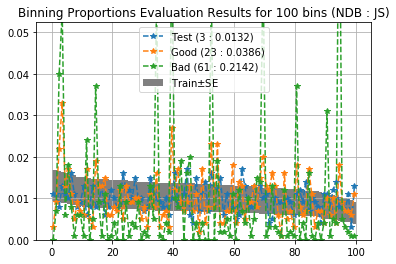

In [4]:
if __name__ == "__main__":
    dim=100
    k=100
    n_train = k*100
    n_test = k*10
    train_samples = np.random.uniform(size=[n_train, dim])
    ndb = NDB(training_data=train_samples, number_of_bins=k, whitening=True)
    test_samples = np.random.uniform(high=1.0, size=[n_test, dim])
    ndb.evaluate(test_samples, model_label='Test')
    test_samples = np.random.uniform(high=0.9, size=[n_test, dim])
    ndb.evaluate(test_samples, model_label='Good')
    test_samples = np.random.uniform(high=0.75, size=[n_test, dim])
    ndb.evaluate(test_samples, model_label='Bad')
    ndb.plot_results(models_to_plot=['Test', 'Good', 'Bad'])